In [1]:
import pandas as pd
import sklearn
import joblib
import matplotlib.pyplot as plt

## Display Settings

In [2]:
pd.set_option('display.max_columns', None)   # This tells Pandas to display all columns of a DataFrame when you print or view it, regardless
                                             # of how many columns there are

In [3]:
# sklearn.set_config(transform_output= 'pandas')      # this command ensures that when scikit-learn transformations (such as scaling or encoding)
# return data, they will output the results as Pandas DataFrames instead of the default NumPy arrays. But this part should be there only when you are
# working on your dataset to train your model (and the below part should be commented out while running this part) so that you can get the clear view
# of every transformation in your dataframe.

In [4]:
# But once you are done training with your model and is about to make the predictions in your website, you should comment the above part and run this part
# of the code so that we get a smooth experience while predicting your values in our website.
sklearn.set_config(transform_output= 'default')

## Importing the datasets

In [5]:
train_df= pd.read_csv('training_data.csv')   # No need to use google.colab here as we had imported the datasets in our file section on the left
test_df= pd.read_csv('testing_data.csv')
val_df= pd.read_csv('validation_data.csv')

## Split the Data

In [6]:
def split_data(data):
  x= data.drop(['Price'], axis=1)
  y= data['Price']
  return x,y

In [7]:
x_train, y_train= split_data(train_df)
x_val, y_val= split_data(val_df)
x_test, y_test= split_data(test_df)

In [8]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          640 non-null    object
 1   Date_of_Journey  640 non-null    object
 2   Source           640 non-null    object
 3   Destination      640 non-null    object
 4   Dep_Time         640 non-null    object
 5   Arrival_Time     640 non-null    object
 6   Duration         640 non-null    int64 
 7   Total_Stops      640 non-null    int64 
 8   Additional_Info  640 non-null    object
dtypes: int64(2), object(7)
memory usage: 45.1+ KB


## Data Pre-processing

In [9]:
x_train.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Dep_Time',
       'Arrival_Time', 'Duration', 'Total_Stops', 'Additional_Info'],
      dtype='object')

In [10]:
date_time_columns= ['Date_of_Journey', 'Dep_Time', 'Arrival_Time']
num_columns= ['Duration', 'Total_Stops']
categorical_columns= [col for col in x_train.columns if (col not in date_time_columns) and (col not in num_columns)]

In [11]:
categorical_columns

['Airline', 'Source', 'Destination', 'Additional_Info']

In [12]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [14]:
# !pip install feature_engine         # Comment out this part while pushing it to github as we don't require it there because for that we are using
                # 'requirements.txt' to install our dependencies on render. But for the sake of this notebook we will uncomment this part and execute
                # this cell as it is required here

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.0/375.0 kB 19.2 MB/s eta 0:00:00


In [15]:
from feature_engine.datetime import DatetimeFeatures

In [16]:
num_transformer= Pipeline(steps=[
    ("imputer", SimpleImputer(strategy= "median")),
    ('scaler', StandardScaler())
])

cat_transformer= Pipeline(steps=[
    ("imputer", SimpleImputer(strategy= "most_frequent")),
    ('scaler', OneHotEncoder(sparse_output= False, handle_unknown= 'ignore'))
])

date_of_journey_transformer= Pipeline(steps=[
    ("imputer", SimpleImputer(strategy= "most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract= ['month', 'week', 'day_of_week', 'day_of_month'], format= 'mixed')),
    ("scaler", StandardScaler())
])

time_transformer= Pipeline(steps=[
    ("imputer", SimpleImputer(strategy= "most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract= ['hour', 'minute'], format= 'mixed')),
    ("scaler", StandardScaler())
])

In [17]:
preprocessor= ColumnTransformer(transformers= [
    ('num', num_transformer, num_columns),
    ('cat', cat_transformer, categorical_columns),
    ('date_of_journey', date_of_journey_transformer, ["Date_of_Journey"]),
    ('time', time_transformer, ["Dep_Time", "Arrival_Time"])
])

In [18]:
preprocessor.fit_transform(x_train) # Our training data is not pre-processed here, it's just an example to show how our dataset will look
                                    # after being pre-processed

array([[-0.16464424,  0.24585829,  0.        , ..., -1.02022634,
         0.38823844, -0.87446988],
       [-0.97269806, -1.23856913,  0.        , ...,  1.61686921,
        -0.79355752,  0.57317814],
       [-0.14365583,  0.24585829,  0.        , ..., -0.49280723,
         1.2745854 ,  0.28364853],
       ...,
       [-0.16464424,  0.24585829,  0.        , ..., -1.02022634,
         0.38823844, -0.87446988],
       [ 2.249023  ,  0.24585829,  0.        , ...,  0.29832143,
         0.97913641,  1.15223735],
       [ 0.37056023,  0.24585829,  0.        , ...,  0.03461188,
        -0.64583302,  1.15223735]])

## Model Selection

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
# We will use hit and try method to train our model and to see which algorithm gives us the best result and that will be considered as the
# final algorithm for our model

In [20]:
algorithms= {
    "Linear Regression" : LinearRegression(),
    "Support Vector Machine" : SVR(),
    "Random Forest" : RandomForestRegressor(n_estimators= 10),
    "XG Boost" : XGBRegressor(n_estimators= 10)
}

In [21]:
data= pd.concat([train_df, val_df], axis=0)     # Don't think about why we did this step, just understand what we did and move on coz this
                                                # is just a correction of splitting our original training data into new train data and val data

x_data, y_data= split_data(data)

## Getting our model performances using Learning Curves
For the learning curves part we will use the R2-score here

In [22]:
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve

In [23]:
import numpy as np

In [24]:
def plot_curves(sizes, mean_scores, std_scores, label, axis):
  axis.plot(sizes, mean_scores, marker= 'o', label= label)

  axis.fill_between(x= sizes,
                    y1= mean_scores - std_scores,
                    y2= mean_scores + std_scores,
                    alpha= 0.5)

In [25]:
def plot_learning_curves(name, algo):
  model= Pipeline([
      ("preprocess", preprocessor),  # Whenever we will call for model.fit() or model.predict(), it will preprocess the entire_dataset/data
                                     # first because of this step and then will perform the respective operation
      ("algorithm", algo)    # After the above step, the model will perform the respective operation using the given algorithm here
  ])

  train_sizes, train_scores, test_scores= learning_curve(estimator= model,
                                                         X= x_data,
                                                         y= y_data,
                                                         cv= 3,
                                                         scoring= 'r2',
                                                         n_jobs= -1,
                                                         random_state= 42)

  mean_train_scores= np.mean(train_scores, axis= 1)
  std_train_scores= np.std(train_scores, axis= 1)    # Standard Deviation
  train_score= f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"

  mean_test_scores= np.mean(test_scores, axis= 1)
  std_test_scores= np.std(test_scores, axis= 1)    # Standard Deviation
  test_score= f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

  fig, axis= plt.subplots(figsize= (12, 4))

  # For training curve
  plot_curves(train_sizes, mean_train_scores, std_train_scores, f"Train ({train_score})", axis)

  # For testing curve
  plot_curves(train_sizes, mean_test_scores, std_test_scores, f"Test ({test_score})", axis)

  axis.set(xlabel= "Training Set Sizes", ylabel= "r2- squared scores", title= name)

  axis.legend(loc= "lower right")

  plt.show()

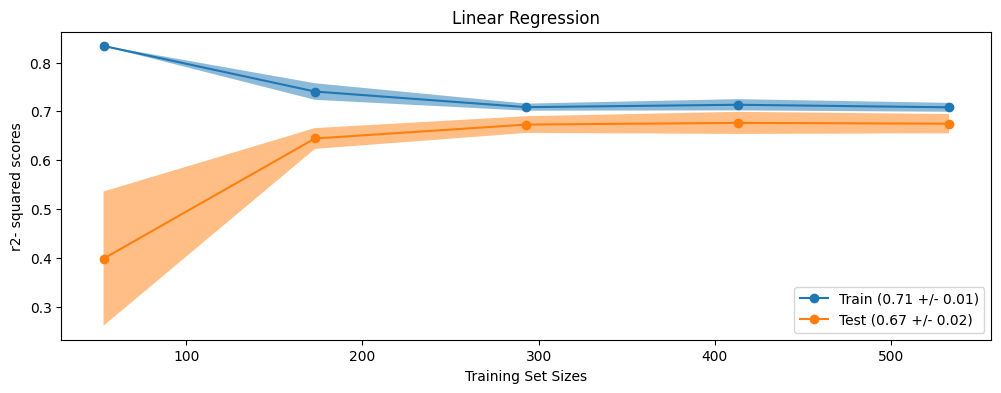

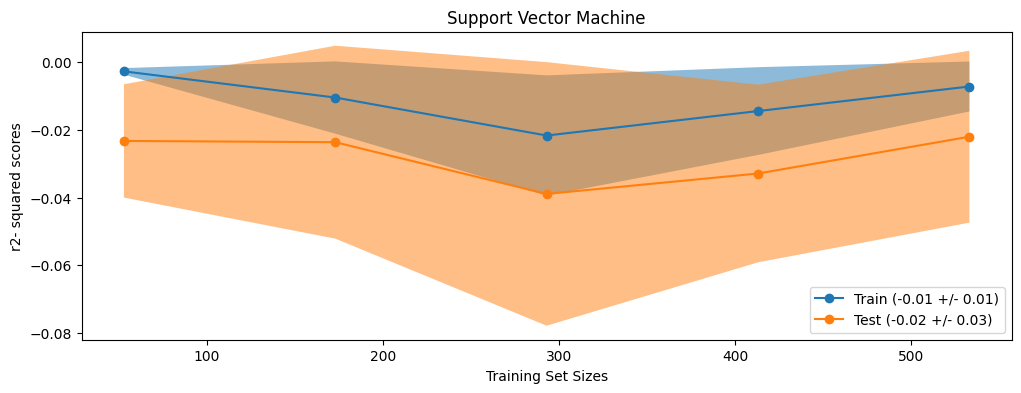

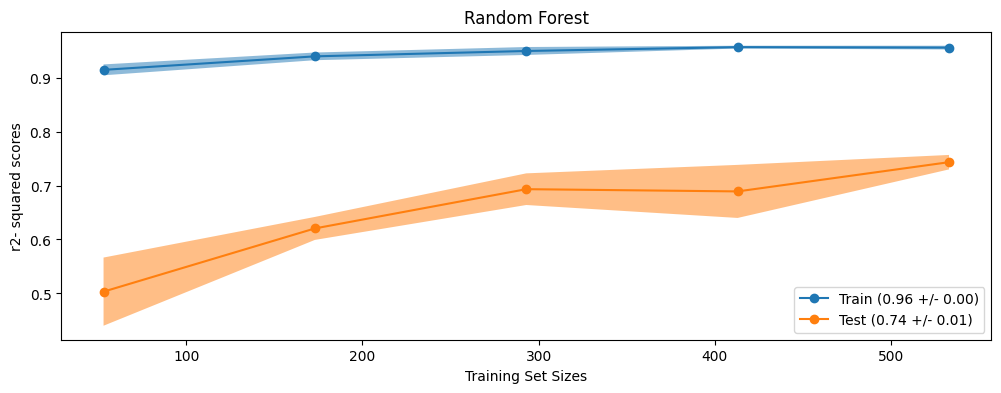

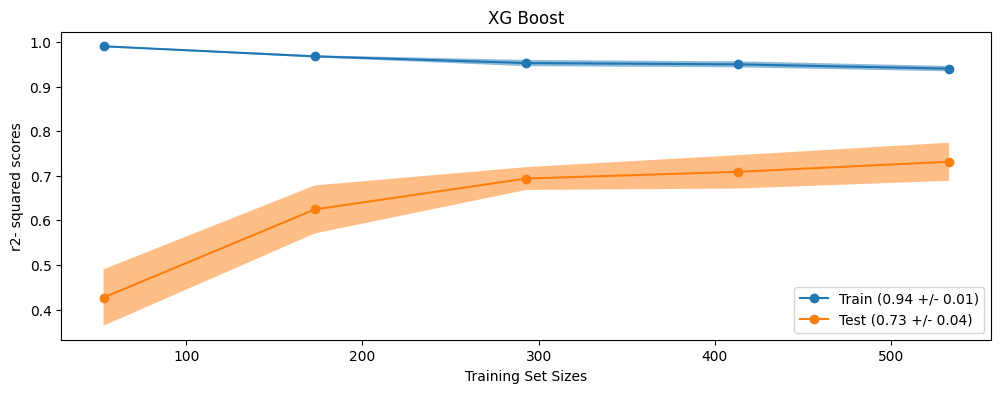

In [26]:
for name, alg in algorithms.items():
  plot_learning_curves(name, alg)

Now by looking at those curves, we are thinking to go with random forest because in random forest the performance goes on incresing with increased number of training datasets.

## Model Training

In [27]:
model= Pipeline(steps= [
    ("preprocess", preprocessor),
    ("algorithm", RandomForestRegressor(n_estimators= 10))
])

In [28]:
x_data

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Multiple Carriers,2019-06-01,Delhi,Cochin,07:05:00,16:10:00,545,1,No Info
1,SpiceJet,2019-06-09,Banglore,Delhi,05:55:00,08:35:00,160,0,No Info
2,Multiple Carriers,2019-05-18,Delhi,Cochin,13:15:00,22:30:00,555,1,No Info
3,Air India,2019-03-09,Banglore,New Delhi,10:30:00,21:25:00,655,2,No Info
4,Air India,2019-06-24,Delhi,Cochin,12:00:00,07:40:00,1180,2,No Info
...,...,...,...,...,...,...,...,...,...
155,Jet Airways,2019-03-15,Mumbai,Hyderabad,19:35:00,21:05:00,90,0,No Info
156,Jet Airways,2019-06-09,Kolkata,Banglore,20:25:00,18:00:00,1295,1,No Info
157,IndiGo,2019-05-27,Delhi,Cochin,14:25:00,17:40:00,195,0,No Info
158,Jet Airways,2019-03-24,Kolkata,Banglore,16:55:00,04:45:00,710,1,No Info


In [29]:
model.fit(x_data, y_data)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Duration', 'Total_Stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Airline', 'Sou...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Date_of_Journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Dep_Time',
                                                   'Arrival_Time'])])),
                ('algorithm', RandomForestRegressor(n_estimators=10))])

In [30]:
def evaluate_model(x, y):
  y_pred= model.predict(x)
  return r2_score(y, y_pred)

print(f" R2 Score on training data is {evaluate_model(x_data, y_data)}")
print(f" R2 Score on testing data is {evaluate_model(x_test, y_test)}")

 R2 Score on training data is 0.9602611760379142
 R2 Score on testing data is 0.7959639751806595


## Downloading our model

In [31]:
import joblib
joblib.dump(model, "model.joblib")

['model.joblib']

## Loading our model to see if it's properly working or not

In [32]:
saved_model = joblib.load("model.joblib")
saved_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Duration', 'Total_Stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Airline', 'Sou...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Date_of_Journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Dep_Time',
                                                   'Arrival_Time'])])),
                ('algorithm', RandomForestRegressor(n_estimators=10))])

In [33]:
y_pred = saved_model.predict(x_test)

print(evaluate_model(x_test, y_test))

0.7959639751806595


Therefore it's working properly and now we are good to go

In [34]:
!pip freeze > requirements.txt        # This part is not required for the code purpose, we are doing it because we want to deploy this project to render and
                                      # there are some dependencies which we needed to create

Now see the requirements.txt has been uploaded in the file section on the left, simply download that file push it to your respective repository in github